In [305]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import json
import vocabulary
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from adjustText import adjust_text

In [306]:
# Create dataframe from excel file
df = pd.read_excel('golden_standard.xlsx', sheet_name='Annotation R2')
df.head()

,item/name,item/artist,mood D,mood B,mood S,mood K,Average mood,Unnamed: 7,Fleiss Kappa,positive,neutral,negative,Unnamed: 12,SUM SQ,sum sq/(4*3)
0,​abcdefu,GAYLE,negative,negative,negative,negative,-1.00,negative,NaN,0,0.0,4.0,NaN,12,1.0
1,22,Taylor Swift,positive,positive,positive,positive,1.00,positive,NaN,4,0.0,0.0,NaN,12,1.0
2,A Thousand Miles,Vanessa Carlton,negative,negative,negative,negative,-1.00,negative,NaN,0,0.0,4.0,NaN,12,1.0
3,All Time Low,Jon Bellion(?)/The Wanted,negative,negative,negative,negative,-1.00,negative,NaN,0,0.0,4.0,NaN,12,1.0
4,All You Wanted,Michelle Branch,negative,negative,neutral,negative,-0.75,negative,NaN,0,1.0,3.0,NaN,6,0.5


In [307]:
# Drop unnecessary columns
try:
    df.drop(columns=['Unnamed: 7', 'Fleiss Kappa', 'Unnamed: 12', 'SUM SQ', 'sum sq/(4*3)'], inplace=True)
except KeyError:
    pass
df.head()

,item/name,item/artist,mood D,mood B,mood S,mood K,Average mood,positive,neutral,negative
0,​abcdefu,GAYLE,negative,negative,negative,negative,-1.00,0,0.0,4.0
1,22,Taylor Swift,positive,positive,positive,positive,1.00,4,0.0,0.0
2,A Thousand Miles,Vanessa Carlton,negative,negative,negative,negative,-1.00,0,0.0,4.0
3,All Time Low,Jon Bellion(?)/The Wanted,negative,negative,negative,negative,-1.00,0,0.0,4.0
4,All You Wanted,Michelle Branch,negative,negative,neutral,negative,-0.75,0,1.0,3.0


In [308]:
# Rename columns
df.rename(columns={
                    'item/name': 'song', 
                    'item/artist': 'artist', 
                    'mood D': 'dagmara', 
                    'mood B': 'barbara', 
                    'mood S': 'szymon', 
                    'mood K': 'kamila', 
                    'Average mood': 'avg_mood'
                }, inplace=True)
df.head()


,song,artist,dagmara,barbara,szymon,kamila,avg_mood,positive,neutral,negative
0,​abcdefu,GAYLE,negative,negative,negative,negative,-1.00,0,0.0,4.0
1,22,Taylor Swift,positive,positive,positive,positive,1.00,4,0.0,0.0
2,A Thousand Miles,Vanessa Carlton,negative,negative,negative,negative,-1.00,0,0.0,4.0
3,All Time Low,Jon Bellion(?)/The Wanted,negative,negative,negative,negative,-1.00,0,0.0,4.0
4,All You Wanted,Michelle Branch,negative,negative,neutral,negative,-0.75,0,1.0,3.0


In [309]:
# Identify the end of sheet and cut dataframe
df = df[:69]
# df.tail(20)

In [310]:
# Convert values in 'neutral' and 'negative' to integers
df.neutral = df.neutral.astype(int)
df.negative = df.negative.astype(int)
df.head(10)

,song,artist,dagmara,barbara,szymon,kamila,avg_mood,positive,neutral,negative
0,​abcdefu,GAYLE,negative,negative,negative,negative,-1.00,0,0,4
1,22,Taylor Swift,positive,positive,positive,positive,1.00,4,0,0
2,A Thousand Miles,Vanessa Carlton,negative,negative,negative,negative,-1.00,0,0,4
3,All Time Low,Jon Bellion(?)/The Wanted,negative,negative,negative,negative,-1.00,0,0,4
4,All You Wanted,Michelle Branch,negative,negative,neutral,negative,-0.75,0,1,3
5,Amnesia,5 Seconds of Summer,negative,negative,negative,negative,-1.00,0,0,4
6,Applause,Lady Gaga,positive,positive,neutral,positive,0.75,3,1,0
7,Astronaut in the Ocean,Masked Wolf,negative,negative,neutral,negative,-0.75,0,1,3
8,Back to December,Taylor Swift,negative,neutral,negative,negative,-0.75,0,1,3
9,Beautiful,Christina Aguilera,positive,positive,negative,positive,0.50,3,0,1


In [311]:
# Create a dataframe for illustrating the hardest songs to annotate manually 
df["disagreement"] = df.positive * df.negative
sorted_df = df.sort_values(by='disagreement', ascending=False)
sorted_df.head(4)

,song,artist,dagmara,barbara,szymon,kamila,avg_mood,positive,neutral,negative,disagreement
34,Let Me Love You,DJ Snake,positive,negative,negative,positive,0.0,2,0,2,4
10,Believing,The Calling,positive,negative,positive,negative,0.0,2,0,2,4
31,I'm Like a Bird,Nelly Furtado,positive,positive,negative,positive,0.5,3,0,1,3
57,Sugar,Maroon 5,negative,positive,negative,negative,-0.5,1,0,3,3


In [312]:
# Map annotations to their values
four_ratings = [sorted_df[['dagmara', 'barbara', 'szymon', 'kamila']].iloc[i].values.tolist() for i in range(4)]
ratings = [list(map(lambda rating: 1 if rating == "positive" else -1, song)) for song in four_ratings]
ratings

[[1, -1, -1, 1], [1, -1, 1, -1], [1, 1, -1, 1], [-1, 1, -1, -1]]

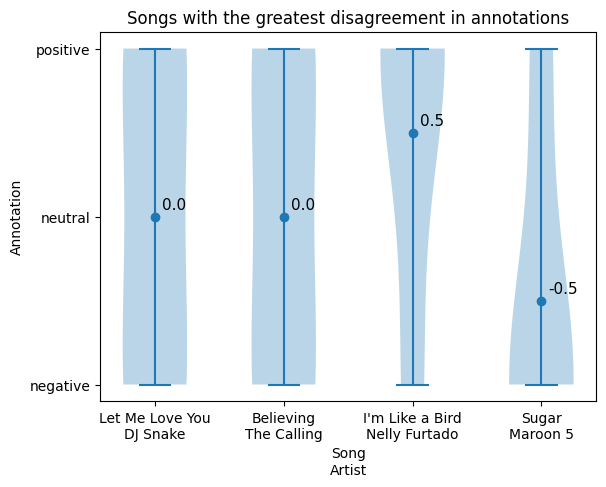

In [313]:
# Visualise the songs with greatest disagreement in annotations
boxplot = plt.violinplot(ratings)
plt.xticks(range(1, len(ratings) + 1),  labels=sorted_df[:4]["song"]+"\n"+sorted_df[:4]["artist"], rotation=0)
plt.yticks([1, 0, -1], ['positive', 'neutral', 'negative'])
plt.xlabel('Song\nArtist')
plt.ylabel('Annotation')
plt.title('Songs with the greatest disagreement in annotations')
colors = ['lightblue', 'lightgreen', 'lightpink', 'lightyellow']
plt.scatter(range(1, len(ratings) + 1), sorted_df[:4]["avg_mood"], marker="o")
for i, j in zip(range(1, len(ratings) + 1), sorted_df[:4]["avg_mood"]):
    plt.annotate(str(j), xy=(i, j), xytext=(5, 5), textcoords="offset points", fontsize=11)
# Remember to comment-out title when saving the plot
# plt.savefig(fname='plots/annotation_disagreement.png',bbox_inches='tight', dpi=300)
plt.show()

In [314]:
# Load songs and show example
with open("../Genius/english_song_lyrics/top_hits_2000__2009.json.json", "r") as f:
    songs_1 = json.load(f)["item"]
with open("../Genius/english_song_lyrics/english_top_hits_2010s.json.json", "r") as f:
    songs_2 = json.load(f)["item"]
with open("../Genius/english_song_lyrics/english_top-hits_2022-23.json.json", "r") as f:
    songs_3 = json.load(f)["item"]
songs = songs_1 + songs_2 + songs_3
songs[0]

{'name': "Everybody's Changing",
 'artist': 'Keane',
 'lyrics': ['You say you wander your own land',
  'But when I think about it',
  "I don't see how you can",
  "You're aching, you're breaking",
  'And I can see the pain in your eyes',
  "Says everybody's changing",
  "And I don't know why",
  'So little time',
  "Try to understand that I'm",
  'Trying to make a move just to stay in the game, I',
  'Try to stay awake and remember my name',
  ',',
  'but',
  "Everybody's changing",
  "And I don't feel the same",
  "You're gone from here",
  "Soon you'll disappear",
  'Fading into beautiful light',
  "'Cause everybody's changing",
  "And I don't feel right",
  'So little time',
  "Try to understand that I'm",
  'Trying to make a move just to stay in the game, I',
  'Try to stay awake and remember my name, but',
  "Everybody's changing",
  "And I don't feel the same",
  '',
  'So little time',
  "Try to understand that I'm",
  'Trying to make a move just to stay in the game, I',
  'Try 

In [315]:
# Get our four songs and remove a duplicate
four_songs = [s for s in songs if s["name"] in sorted_df[:4]["song"].values.tolist()]
four_songs.pop(1)
assert len(four_songs) == 4
for s in four_songs:
    print(s["name"])

I'm Like a Bird
Believing
Sugar
Let Me Love You


In [316]:
# Choose song for transformation and plotting
this_song = four_songs[3]

In [317]:
# Full song lyric
vocabulary.print_lyrics(this_song)

I used to believe
We were burnin' on the edge of somethin' beautiful (Somethin' beautiful)
Somethin' beautiful (Somethin' beautiful)
Sellin' a dream
Smoke and mirrors keep us waitin' on a miracle (Oh)
On a miracle (Oh)
Say, go through the darkest of days
Heaven's a heartbreak away
Never let you go, never let me down
Oh, it's been a hell of a ride
Driving the edge of a knife
Never let you go, never let me down
Don't you give up, nah-nah-nah
I won't give up, nah-nah-nah
Let me love you
Let me love you
Don't you give up, nah-nah-nah
I won't give up, nah-nah-nah
Let me love you
Let me love you
Oh, no, no, no,
no, no
Oh, no, no, no, no

(Oh-oh)
(Oh-oh)
(Oh-oh-oh)
Don't fall asleep (Ooh)
At the wheel, we've got a million miles ahead of us
Miles ahead of us
All that we need (Oh)
Is a rude awakening to know we're good enough
(Yeah) Know we're good enough
Say, go through the darkest of days
Heaven's a heartbreak away
Never let you go, never let me down
Oh it's been a hell of a ride
Driving the 

In [318]:
# Divide song lyrics into words, remove stopwords
wordlist = vocabulary.words(this_song)
# Removing stopwords is not recommended for sentiment analysis but we are not doing it here
wordlist_no_stopwords = vocabulary.remove_stopwords(wordlist)
print(f"{len(wordlist)=}, {len(wordlist_no_stopwords)=}")
print(f"{wordlist=}")
print(f"{wordlist_no_stopwords=}")

len(wordlist)=407, len(wordlist_no_stopwords)=91
wordlist=['i', 'used', 'to', 'believe', 'we', 'were', 'burnin', 'on', 'the', 'edge', 'of', 'somethin', 'beautiful', 'somethin', 'beautiful', 'somethin', 'beautiful', 'somethin', 'beautiful', 'sellin', 'a', 'dream', 'smoke', 'and', 'mirrors', 'keep', 'us', 'waitin', 'on', 'a', 'miracle', 'oh', 'on', 'a', 'miracle', 'oh', 'say', 'go', 'through', 'the', 'darkest', 'of', 'days', 'heaven', 's', 'a', 'heartbreak', 'away', 'never', 'let', 'you', 'go', 'never', 'let', 'me', 'down', 'oh', 'it', 's', 'been', 'a', 'hell', 'of', 'a', 'ride', 'driving', 'the', 'edge', 'of', 'a', 'knife', 'never', 'let', 'you', 'go', 'never', 'let', 'me', 'down', 'don', 't', 'you', 'give', 'up', 'nah', 'nah', 'nah', 'i', 'won', 't', 'give', 'up', 'nah', 'nah', 'nah', 'let', 'me', 'love', 'you', 'let', 'me', 'love', 'you', 'don', 't', 'you', 'give', 'up', 'nah', 'nah', 'nah', 'i', 'won', 't', 'give', 'up', 'nah', 'nah', 'nah', 'let', 'me', 'love', 'you', 'let', 'me', '

In [319]:
# Count words, sort by frequency, exclude rare words
counter = vocabulary.counter(wordlist_no_stopwords)
alphabetical_counter = vocabulary.alphabetical_counter(counter)
alphabetical_counter

{'ahead': 2,
 'asleep': 1,
 'awakening': 1,
 'beautiful': 4,
 'believe': 1,
 'burnin': 1,
 'darkest': 2,
 'days': 2,
 'dream': 1,
 'driving': 2,
 'edge': 3,
 'fall': 1,
 'heartbreak': 2,
 'heaven': 2,
 'hell': 2,
 'knife': 2,
 'love': 12,
 'miles': 2,
 'million': 1,
 'miracle': 2,
 'mirrors': 1,
 'oh': 24,
 'ooh': 1,
 'ride': 2,
 'rude': 1,
 'sellin': 1,
 'smoke': 1,
 'somethin': 4,
 've': 1,
 'waitin': 1,
 'wheel': 1,
 'woah': 1,
 'won': 6}

In [320]:
# Quantify importance of the word in the song
stop_words = vocabulary.stopwords()
lyrics = [" ".join(s["lyrics"]) for s in songs]
# Vectorize over all songs
vectorizer = TfidfVectorizer(stop_words=stop_words, min_df=0.001)
# tf(t,d) = count of t in d / number of words in d
tf_idf = vectorizer.fit_transform(this_song['lyrics'])
feature_names = vectorizer.get_feature_names_out()
scores = tf_idf.toarray()[0]
word_scores = dict(zip(feature_names, scores))
word_scores = {k: v for (k, v) in word_scores.items() if v > 0.0}
word_scores

{'believe': 1.0}

In [321]:
# Load lexicon that is used for sentiment analysis in vader
vader = pd.read_csv("vader_lexicon.txt", sep="\t", names=['token', 'mean-sentiment-rating', 'standard-deviation', 'raw-human-sentiment-ratings'])
vader.head()
# Transform it to dictionary for easy use
token_sentiment = {token.strip(): sentiment for (token, sentiment) in zip(vader["token"].values.tolist(), vader["mean-sentiment-rating"].values.tolist())}
# Test lexicon
assert token_sentiment["beating"] == -2.0
token_sentiment

{'$:': -1.5,
 '%)': -0.4,
 '%-)': -1.5,
 '&-:': -0.4,
 '&:': -0.7,
 "( '}{' )": 1.6,
 '(%': -0.9,
 "('-:": 2.2,
 "(':": 2.3,
 '((-:': 2.1,
 '(*': 1.1,
 '(-%': -0.7,
 '(-*': 1.3,
 '(-:': 1.6,
 '(-:0': 2.8,
 '(-:<': -0.4,
 '(-:o': 1.5,
 '(-:O': 1.5,
 '(-:{': -0.1,
 '(-:|>*': 1.9,
 '(-;': 1.3,
 '(-;|': 2.1,
 '(8': 2.6,
 '(:': 2.2,
 '(:0': 2.4,
 '(:<': -0.2,
 '(:o': 2.5,
 '(:O': 2.5,
 '(;': 1.1,
 '(;<': 0.3,
 '(=': 2.2,
 '(?:': 2.1,
 '(^:': 1.5,
 '(^;': 1.5,
 '(^;0': 2.0,
 '(^;o': 1.9,
 '(o:': 1.6,
 ")':": -2.0,
 ")-':": -2.1,
 ')-:': -2.1,
 ')-:<': -2.2,
 ')-:{': -2.1,
 '):': -1.8,
 '):<': -1.9,
 '):{': -2.3,
 ');<': -2.6,
 '*)': 0.6,
 '*-)': 0.3,
 '*-:': 2.1,
 '*-;': 2.4,
 '*:': 1.9,
 '*<|:-)': 1.6,
 '*\\0/*': 2.3,
 '*^:': 1.6,
 ',-:': 1.2,
 "---'-;-{@": 2.3,
 '--<--<@': 2.2,
 '.-:': -1.2,
 '..###-:': -1.7,
 '..###:': -1.9,
 '/-:': -1.3,
 '/:': -1.3,
 '/:<': -1.4,
 '/=': -0.9,
 '/^:': -1.0,
 '/o:': -1.4,
 '0-8': 0.1,
 '0-|': -1.2,
 '0:)': 1.9,
 '0:-)': 1.4,
 '0:-3': 1.5,
 '0:03': 1.9,
 '

In [322]:
# From list of words for the song, get words with nonzero sentiment and words with nonzero TF-IDF score
word_tfidf_sentiment = {}
for w in wordlist_no_stopwords:
    tf_idf = 0.0 if w not in word_scores else word_scores[w]
    sentiment = 0.0 if w not in token_sentiment else token_sentiment[w]
    if tf_idf == 0.0 == sentiment: 
        continue
    word_tfidf_sentiment[w] = (tf_idf, sentiment)
print(word_tfidf_sentiment)

{'believe': (1.0, 0.0), 'beautiful': (0.0, 2.9), 'dream': (0.0, 1.0), 'miracle': (0.0, 2.8), 'darkest': (0.0, -2.2), 'heaven': (0.0, 2.3), 'heartbreak': (0.0, -2.7), 'hell': (0.0, -3.6), 'won': (0.0, 2.7), 'love': (0.0, 3.2), 'rude': (0.0, -2.0)}


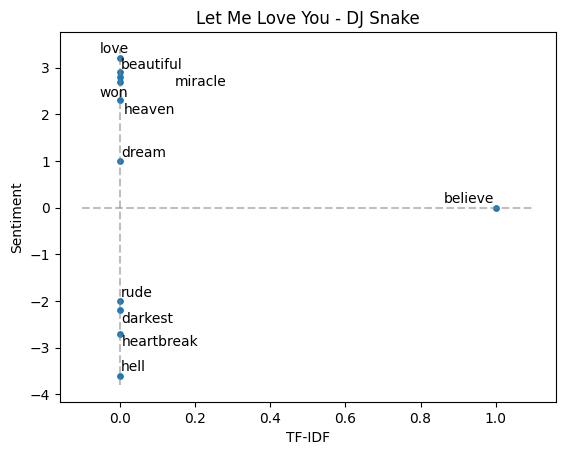

In [323]:
tfidf_values, sentiment_values = zip(*word_tfidf_sentiment.values())
plt.scatter(tfidf_values, sentiment_values, s=15)
texts = []
for w, (t, s) in zip(word_tfidf_sentiment.keys(), word_tfidf_sentiment.values()):
    t = plt.annotate(w, (t, s), ha='center', va='center')
    texts.append(t)
adjust_text(texts)
plt.xlabel("TF-IDF")
plt.ylabel("Sentiment")
plt.vlines(0, min(sentiment_values)-0.2, max(sentiment_values)+0.2, colors='grey', linestyles='dashed', alpha=0.5)
plt.hlines(0, -0.1, max(tfidf_values)+0.1, colors='grey', linestyles='dashed', alpha=0.5)
plt.title(f"{this_song['name']} - {this_song['artist']}")
name = f"{this_song['name']}-{this_song['artist']}".lower().replace(" ", "_")
# plt.savefig(fname=f"plots/{name}.png",bbox_inches='tight', dpi=300)
plt.show()

In [324]:
# Sentiment from vader: Create dataframe from excel file, cut the tail, use only 3 columns, rename columns
df2 = pd.read_excel('golden_standard.xlsx', sheet_name='Model')[:69]
df2 = df2[['item/name', 'item/artist', 'item/rating model']]
df2.rename(columns={
                        'item/name': 'song', 
                        'item/artist': 'artist', 
                        'item/rating model': 'vader',
                    }, inplace=True)
# df2['vader_int'] = df2['vader'].map({'positive': 1, 'negative': -1})
df2.head(1)

,song,artist,vader
0,​abcdefu,GAYLE,negative


In [325]:
# Yes, you can sort dictionaries (since python 3.7)
vader_song_annotation = {s.replace('\u200b', ''): a for (s, a) in zip(df2['song'].values.tolist(), df2['vader'].values.tolist())}
vader_song_annotation = dict(sorted(vader_song_annotation.items(), key=lambda x: x[0]))
vader_song_annotation

{'22': 'positive',
 'A Thousand Miles': 'negative',
 'All Time Low': 'negative',
 'All You Wanted': 'positive',
 'Amnesia': 'positive',
 'Applause': 'positive',
 'Astronaut in the Ocean': 'positive',
 'Back to December': 'positive',
 'Beautiful': 'positive',
 'Believing': 'negative',
 'Bleeding Love': 'positive',
 'Blurred Lines': 'positive',
 'Breathe': 'negative',
 'Chasing Cars': 'negative',
 'Chasing the Sun': 'positive',
 'Clocks': 'negative',
 'Crystal Ball': 'positive',
 'Dark Horse': 'positive',
 'Diamonds': 'positive',
 'Disturbia': 'positive',
 "Don't Tell Me": 'positive',
 'Early Winter': 'positive',
 "Fallin' for You": 'positive',
 'First Time': 'positive',
 'Glad You Came': 'positive',
 'Hey Ya!': 'positive',
 'High Enough': 'positive',
 'Hope': 'negative',
 'Hot N Cold': 'negative',
 'I Will Remember You': 'positive',
 "I'm Like a Bird": 'positive',
 'Insomnia': 'positive',
 'Keep Holding On': 'positive',
 'Let Me Love You': 'positive',
 'Levitating': 'positive',
 'Life F

In [326]:
# Sentiment from distilbert
mood_value = {'positive': 1, 'negative': -1, 'neutral': 0}
with open("distilbert.json", "r") as f:
    distilbert = json.load(f)["items"]
len(distilbert)

74

In [327]:
# Yes, you can sort dictionaries (since python 3.7)
distilbert_song_annotation = {song['name'].replace('\u200b', ''): song['mood'] for song in distilbert}
distilbert_song_annotation = dict(sorted(distilbert_song_annotation.items(), key=lambda x: x[0]))
distilbert_song_annotation

{'22': 'positive',
 'A Thousand Miles': 'negative',
 'All Time Low': 'negative',
 'All You Wanted': 'negative',
 'Amnesia': 'negative',
 'Applause': 'positive',
 'Astronaut in the Ocean': 'negative',
 'Back to December': 'negative',
 'Beautiful': 'negative',
 'Believing': 'negative',
 'Bleeding Love': 'negative',
 'Blurred Lines': 'negative',
 'Bones': 'negative',
 'Breathe': 'negative',
 'Chasing Cars': 'negative',
 'Chasing the Sun': 'negative',
 'Clocks': 'negative',
 'Crystal Ball': 'negative',
 'Dark Horse': 'negative',
 'Diamonds': 'positive',
 'Disturbia': 'negative',
 "Don't Tell Me": 'negative',
 'Early Winter': 'negative',
 "Fallin' for You": 'negative',
 'First Time': 'negative',
 'Glad You Came': 'negative',
 'Hey Ya!': 'negative',
 'High Enough': 'negative',
 'Hope': 'negative',
 'Hot N Cold': 'negative',
 'I Will Remember You': 'negative',
 "I'm Like a Bird": 'negative',
 'Insomnia': 'negative',
 'Keep Holding On': 'negative',
 'Let Me Love You': 'positive',
 'Levitating'

In [328]:
# Check for completeness
for k in vader_song_annotation.keys():
    if k not in distilbert_song_annotation:
        print(k)
print("- - - - - - -")
for k in distilbert_song_annotation.keys():
    if k not in vader_song_annotation:
        print(k)

abcdefu
- - - - - - -
Bones


In [329]:
# Remove conflicting songs
del vader_song_annotation['abcdefu']
del distilbert_song_annotation['Bones']
assert vader_song_annotation.keys() == distilbert_song_annotation.keys()

In [330]:
# Sentiment from manual annotation
# This function comes from excel, most of the time forces binary classification
mood = lambda x: 'positive' if x > 0.0 else 'negative' if x < 0.0 else 'neutral'
manual_song_annotation = {s.replace('\u200b', ''): mood(a) for (s, a) in zip(df['song'].values.tolist(), df['avg_mood'].values.tolist())}
manual_song_annotation = dict(sorted(manual_song_annotation.items(), key=lambda x: x[0]))
del manual_song_annotation['abcdefu']
assert manual_song_annotation.keys() == distilbert_song_annotation.keys()

In [331]:
distilbert_song_annotation

{'22': 'positive',
 'A Thousand Miles': 'negative',
 'All Time Low': 'negative',
 'All You Wanted': 'negative',
 'Amnesia': 'negative',
 'Applause': 'positive',
 'Astronaut in the Ocean': 'negative',
 'Back to December': 'negative',
 'Beautiful': 'negative',
 'Believing': 'negative',
 'Bleeding Love': 'negative',
 'Blurred Lines': 'negative',
 'Breathe': 'negative',
 'Chasing Cars': 'negative',
 'Chasing the Sun': 'negative',
 'Clocks': 'negative',
 'Crystal Ball': 'negative',
 'Dark Horse': 'negative',
 'Diamonds': 'positive',
 'Disturbia': 'negative',
 "Don't Tell Me": 'negative',
 'Early Winter': 'negative',
 "Fallin' for You": 'negative',
 'First Time': 'negative',
 'Glad You Came': 'negative',
 'Hey Ya!': 'negative',
 'High Enough': 'negative',
 'Hope': 'negative',
 'Hot N Cold': 'negative',
 'I Will Remember You': 'negative',
 "I'm Like a Bird": 'negative',
 'Insomnia': 'negative',
 'Keep Holding On': 'negative',
 'Let Me Love You': 'positive',
 'Levitating': 'positive',
 'Life F

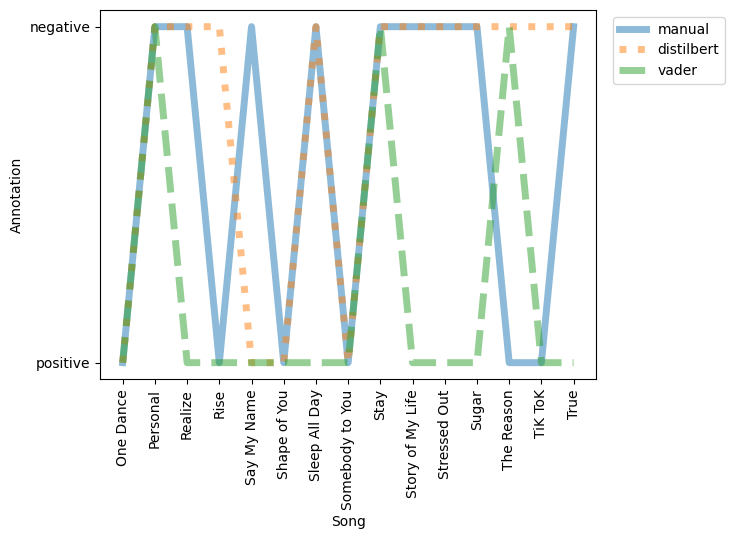

In [335]:
dst = dict(list(distilbert_song_annotation.items())[45:60])
vad = dict(list(vader_song_annotation.items())[45:60])
man = dict(list(manual_song_annotation.items())[45:60])
plt.plot(range(len(man)), man.values(), label='manual', linewidth=5, alpha=0.5, linestyle='solid')
plt.plot(range(len(dst)), dst.values(), label='distilbert', linewidth=5, alpha=0.5, linestyle='dotted')
plt.plot(range(len(vad)), vad.values(), label='vader', linewidth=5, alpha=0.5, linestyle='dashed')
plt.xticks(range(len(dst)), dst.keys(), rotation=90)
plt.ylabel("Annotation")
plt.xlabel("Song")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
# plt.savefig(fname=f"plots/manual_distilber_vader.png",bbox_inches='tight', dpi=300)
plt.show()

In [343]:
# Calculate accuracy for vader and distilbert
vader_score = 0
distilbert_score = 0
for k,v in manual_song_annotation.items():
    if vader_song_annotation[k] == v: vader_score +=1
    if distilbert_song_annotation[k] == v: distilbert_score += 1

vader_accuracy = vader_score/len(manual_song_annotation)
distilbert_accuracy = distilbert_score/len(manual_song_annotation)
print(f"{vader_accuracy=:.2%}, {distilbert_accuracy=:.2%}")

vader_accuracy=52.94%, distilbert_accuracy=72.06%
